In this notebook we will be predicting house price in mexico city based various factors.
The steps to be followed are:

1.Data extraction

2.Data cleaning

3.Data exploration

4.Build our machine learning model

In [ ]:
from glob import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

import warnings
warnings.filterwarnings('ignore')

We will create a wrangle function that will help us in loading the CSV files and cleaning our data

In [ ]:
#load all the data files using glob
files = glob('/content/mexico-city-real-estate*.csv')
files

['/content/mexico-city-real-estate-4.csv',
 '/content/mexico-city-real-estate-5.csv',
 '/content/mexico-city-real-estate-2.csv',
 '/content/mexico-city-real-estate-1.csv',
 '/content/mexico-city-real-estate-3.csv']

In [ ]:
#define a function wrangle that will read the csv files and clean the data
def wrangle(filepath):
  #read csv
  df = pd.read_csv(filepath)

  #1.Subset the data in the CSV file and return only apartments in Mexico City ("Distrito Federal") that cost less than $100,000.
  mask_apt = df['property_type'] == 'apartment'
  mask_location = df['place_with_parent_names'].str.contains('Distrito Federal')
  mask_price = df['price_aprox_usd'] < 100000

  df = df[mask_apt & mask_location & mask_price]

  #2.Remove outliers by trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2".
  low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
  mask_size = df['surface_covered_in_m2'].between(low, high)
  df = df[mask_size]

  #3.Create separate "lat" and "lon" columns.
  df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand = True).astype(float)
  df.drop(columns = 'lat-lon', inplace = True)

  #4.Mexico City is divided into 15 boroughs. Create a "borough" feature from the "place_with_parent_names" column
  df['borough'] = df['place_with_parent_names'].str.split('|',expand = True)[1]
  df.drop(columns = 'place_with_parent_names', inplace = True)

  #5.Drop columns that are more than 50% null values
  df.drop(columns = ['surface_total_in_m2','price_usd_per_m2', 'floor', 'rooms', 'expenses'],  inplace = True)
  #6.Drop columns containing low- or high-cardinality categorical values.
  df.drop(columns =['properati_url', 'currency', 'property_type', 'operation'],inplace = True)
  #7.Drop any columns that would constitute leakage for the target "price_aprox_usd"
  df.drop(columns = ['price_aprox_local_currency', 'price_per_m2'], inplace = True)
  #8.Drop any columns that would create issues of multicollinearity.
  df.drop(columns = 'price', inplace = True)

  return(df)

In [ ]:
df = [wrangle(file) for file in files]
df = pd.concat(df, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,52686.48,65.0,19.389011,-99.180415,Benito Juárez
1,48581.99,66.0,23.634501,-102.552788,Iztacalco
2,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
3,33530.62,69.0,19.429437,-99.143460,Cuauhtémoc
4,23355.39,54.0,19.408007,-99.069186,Iztacalco


<Axes: >

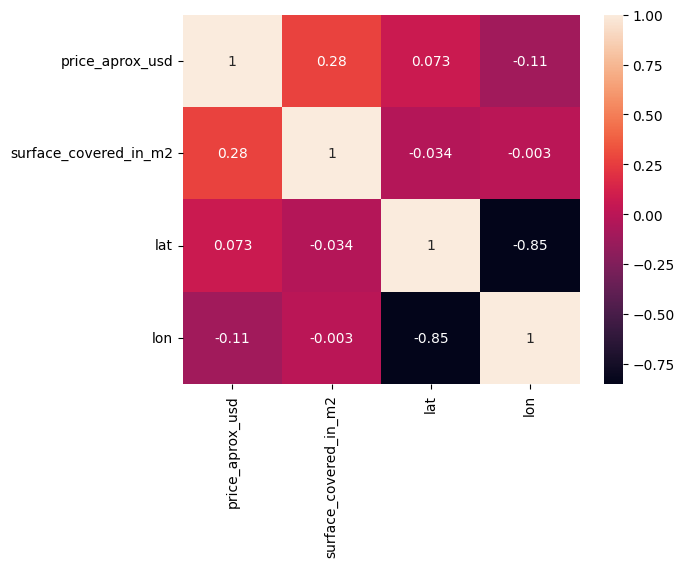

In [ ]:
corr = df.select_dtypes('float').corr()
sns.heatmap(corr, annot = True)

**EDA**

Let's check the distribution of our target variable

Text(0.5, 1.0, 'Distribution of price')

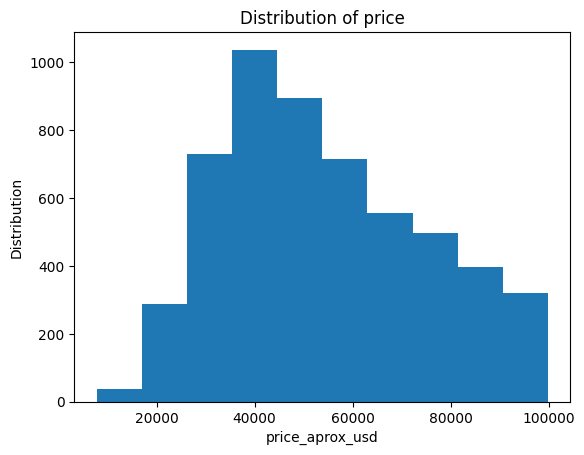

In [ ]:
plt.hist(df['price_aprox_usd'])
plt.xlabel('price_aprox_usd')
plt.ylabel('Distribution')
plt.title('Distribution of price')

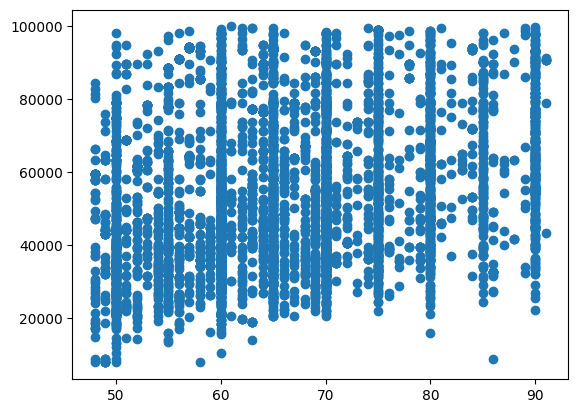

In [ ]:
#lets check the relationship we have between surface covered and price
plt.scatter(x='surface_covered_in_m2', y = 'price_aprox_usd', data = df)

In [ ]:
#lets Create a Mapbox scatter plot that shows the location of the apartments in the dataset and represent their price using color.
fig = px.scatter_mapbox(
    df,
    lat = 'lat',
    lon = 'lon',
    width = 600,
    height = 600,
    color = 'price_aprox_usd',
    hover_data = ['price_aprox_usd']
    )
fig.update_layout(mapbox_style = 'open-street-map')

fig.show()

**SPLIT**

In [ ]:
X = df.drop(columns = 'price_aprox_usd')
y = df['price_aprox_usd']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

**Baseline** **model**

In [ ]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]* len(y_train)

print('Mean apartment price : ' , y_mean)
print('Baseline MAE', mean_absolute_error(y_train, y_pred_baseline))

Mean apartment price :  54284.65159749412
Baseline MAE 17288.699093010957


**Iterate the model**

In [ ]:
model = make_pipeline(
    OneHotEncoder(handle_unknown= 'ignore'),
    SimpleImputer(),
    Ridge()
)

In [ ]:
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

**Evaluate**

In [ ]:
y_model_train = model.predict(X_train)
y_model_test = model.predict(X_test)

print('MAE train pred:', mean_absolute_error(y_train, y_model_train))
print('MAE test pred:', mean_absolute_error(y_test, y_model_test))

MAE train pred: 5536.029381314177
MAE test pred: 9426.398838297207


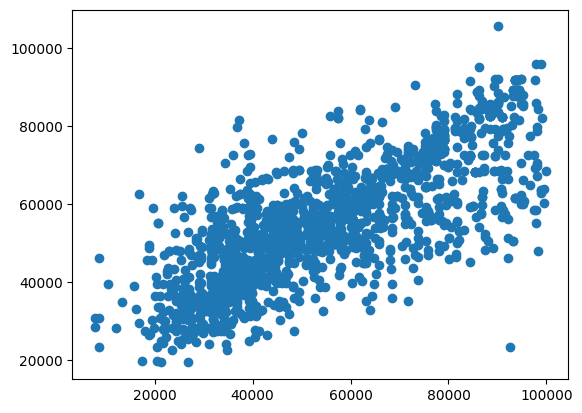

In [ ]:
predictions = model.predict(X_test)
plt.scatter(y_test, predictions)

Communicate results

In [ ]:
def make_predictions(area, lat, lon, neighborhood):
  data = {
      'surface_covered_in_m2' : area,
      'lat' : lat,
      'lon' : lon,
      'borough' : neighborhood
        }
  df = pd.DataFrame(data, index = [0])
  prediction = model.predict(df)[0]
  return f'predicted apartment price : ${prediction}'

In [ ]:
interact(
    make_predictions,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4513146367…